In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


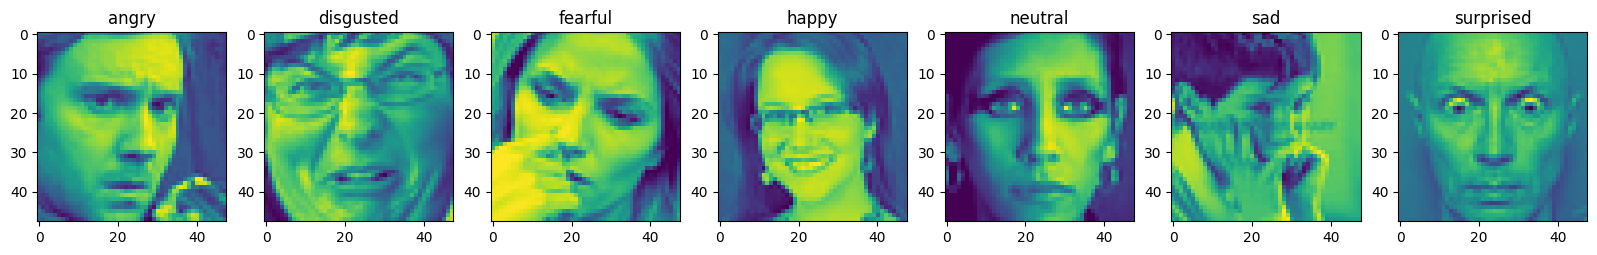

In [2]:
# defining dir variables 
root_dir = 'D://D//Sudharsan//Mini project//FER48//'
train_dir = root_dir + 'train//'
test_dir = root_dir + 'test//'
target_var = os.listdir(train_dir)

# Visualize sample images
fig, axes = plt.subplots(1, 7, figsize=(20,8))
for i in range(len(target_var)):
    d = train_dir + target_var[i] + '/' + os.listdir(train_dir + target_var[i] + '/')[0]
    axes[i].imshow( plt.imread(d) )
    axes[i].set_title(target_var[i])
plt.show()


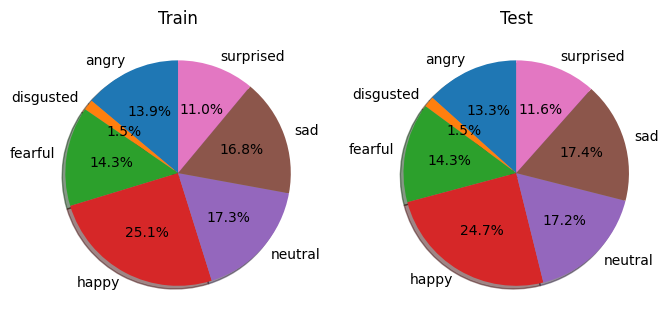

Emotion : angry
	Training : 3995
	 Testing : 958
Emotion : disgusted
	Training : 436
	 Testing : 111
Emotion : fearful
	Training : 4097
	 Testing : 1024
Emotion : happy
	Training : 7215
	 Testing : 1774
Emotion : neutral
	Training : 4965
	 Testing : 1233
Emotion : sad
	Training : 4830
	 Testing : 1247
Emotion : surprised
	Training : 3171
	 Testing : 831


In [3]:
# Load data statistics
x_train = np.array([ len(os.listdir(train_dir+i+'/')) for i in target_var ])
x_test = np.array([ len(os.listdir(test_dir+i+'/')) for i in target_var ])
label = target_var

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

for i in target_var:
    print('Emotion : ' + i )
    print('\tTraining : ' + str(len(os.listdir(train_dir+i+'/'))) +'\n\t Testing : ' + str(len(os.listdir(test_dir+i+'/'))))


In [4]:
# Using IDG to load images from directory
train_idg = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30 percent validation split for training 
test_idg = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size = (48, 48)
batch_size = 64

arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'class_mode' : 'categorical',
             'batch_size': batch_size}
arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'class_mode' : 'categorical',
            'batch_size': batch_size,
            'shuffle': False}

train = train_idg.flow_from_directory(directory=train_dir, subset='training', **arg_train)
valid = train_idg.flow_from_directory(directory=train_dir, subset='validation', **arg_train)
test  = test_idg.flow_from_directory(directory=test_dir, **arg_test)


Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
# Define the model
model = tf.keras.Sequential()

model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7,kernel_initializer='he_normal'))
model.add(Activation('softmax'))
    
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                        

In [6]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fit the model
history = model.fit(
    train,
    validation_data=valid,
    epochs=50
)


Epoch 1/50
315/315 [==============================] - 41s 76ms/step - loss: 2.5533 - accuracy: 0.1847 - val_loss: 1.8860 - val_accuracy: 0.2599
Epoch 2/50
315/315 [==============================] - 20s 64ms/step - loss: 2.1082 - accuracy: 0.2317 - val_loss: 1.7467 - val_accuracy: 0.2955
Epoch 3/50
315/315 [==============================] - 19s 60ms/step - loss: 1.8966 - accuracy: 0.2775 - val_loss: 1.6344 - val_accuracy: 0.3777
Epoch 4/50
315/315 [==============================] - 17s 53ms/step - loss: 1.7141 - accuracy: 0.3442 - val_loss: 1.5791 - val_accuracy: 0.4023
Epoch 5/50
315/315 [==============================] - 17s 53ms/step - loss: 1.6284 - accuracy: 0.3629 - val_loss: 1.5524 - val_accuracy: 0.3925
Epoch 6/50
315/315 [==============================] - 17s 52ms/step - loss: 1.5621 - accuracy: 0.3907 - val_loss: 1.4653 - val_accuracy: 0.4246
Epoch 7/50
315/315 [==============================] - 17s 53ms/step - loss: 1.4925 - accuracy: 0.4211 - val_loss: 1.3785 - val_accuracy:

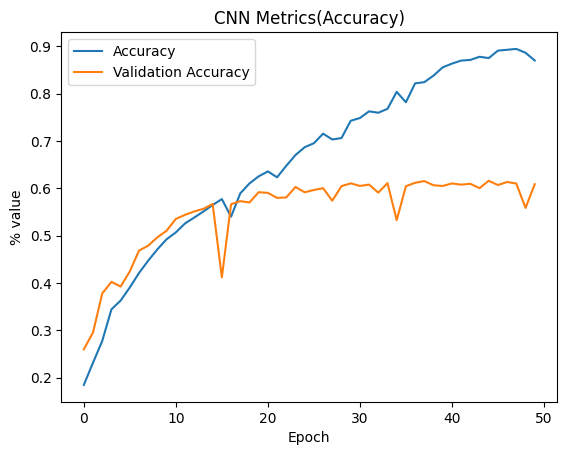

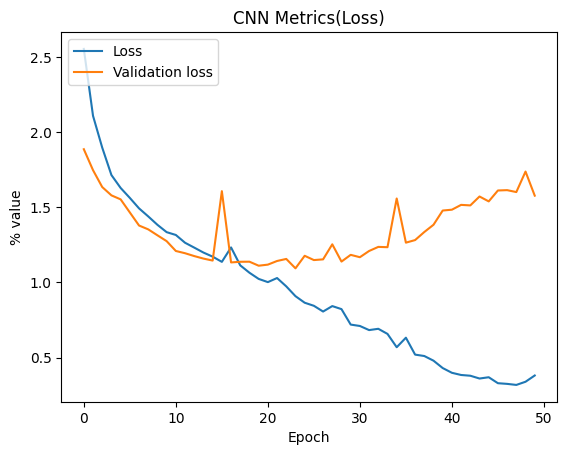

In [7]:
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('CNN Metrics(Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.title('CNN Metrics(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()


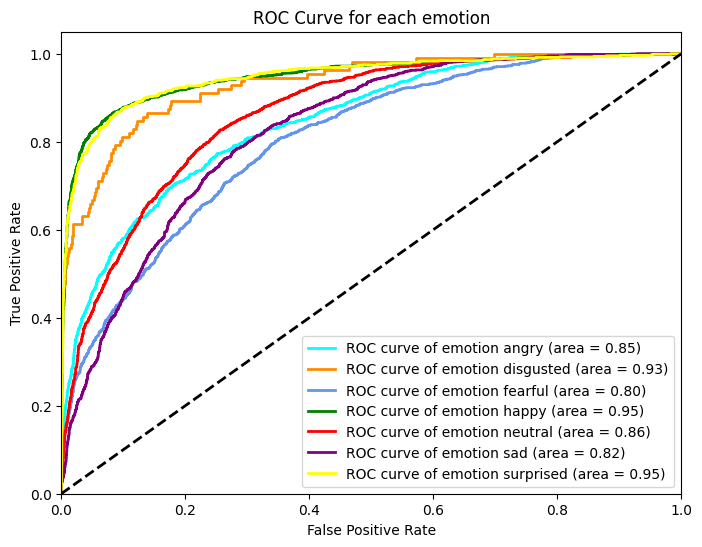

In [8]:
# Predict and evaluate
y_pred = model.predict(test)
y_pred_labels = [np.argmax(i) for i in y_pred]
y_actual = test.classes[test.index_array]
y_actual_bin = label_binarize(y_actual, classes=[0, 1, 2, 3, 4, 5, 6])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_actual_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow'])
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of emotion {0} (area = {1:0.2f})'
             ''.format(target_var[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each emotion')
plt.legend(loc="lower right")
plt.show()


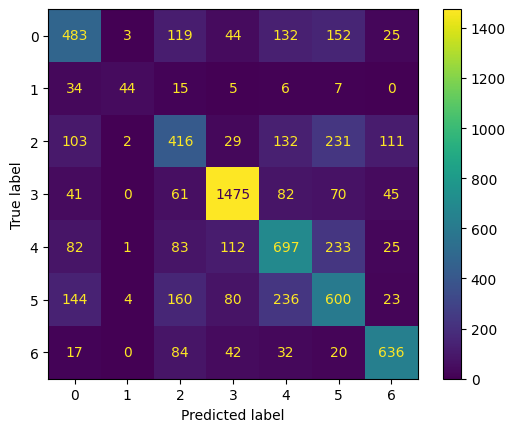

              precision    recall  f1-score   support

           0     0.5343    0.5042    0.5188       958
           1     0.8148    0.3964    0.5333       111
           2     0.4435    0.4062    0.4241      1024
           3     0.8254    0.8315    0.8284      1774
           4     0.5292    0.5653    0.5467      1233
           5     0.4570    0.4812    0.4688      1247
           6     0.7353    0.7653    0.7500       831

    accuracy                         0.6062      7178
   macro avg     0.6199    0.5643    0.5814      7178
weighted avg     0.6066    0.6062    0.6049      7178



In [9]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_actual, y_pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred_labels, digits=4))


In [10]:
# Save the entire model
model.save('Face emotion recognition.h5')
print("Model saved")


Model saved
